In [1]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import argparse

# Données
import wrds

# V3
import yfinance as yf

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Préparation des données DEVISES

In [3]:
currencies = pd.read_csv('currencies.csv')
currencies['date'] = pd.to_datetime(currencies['date'])

print(currencies)

           date   dexalus  dexcaus  dexjpus  dexszus   dexukus
0    2005-01-03  1.283697   1.2108   102.83   1.1466  0.524714
1    2005-01-04  1.304121   1.2248   104.27   1.1674  0.530955
2    2005-01-05  1.302423   1.2236   103.95   1.1673  0.529801
3    2005-01-06  1.313715   1.2371   104.87   1.1733  0.533305
4    2005-01-07  1.319261   1.2333   104.93   1.1859  0.534702
...         ...       ...      ...      ...      ...       ...
5212 2024-12-25       NaN      NaN      NaN      NaN       NaN
5213 2024-12-26  1.605910   1.4404   158.01   0.9000  0.798594
5214 2024-12-27  1.610825   1.4433   157.73   0.9018  0.795355
5215 2024-12-30  1.607976   1.4374   157.26   0.9066  0.798531
5216 2024-12-31  1.616815   1.4400   157.37   0.9068  0.798658

[5217 rows x 6 columns]


In [4]:
# Renommer colonnes 
currencies.columns = ['date', 'AUD', 'CAD', 'JPY', 'CHF', 'GBP']
print(currencies)

           date       AUD     CAD     JPY     CHF       GBP
0    2005-01-03  1.283697  1.2108  102.83  1.1466  0.524714
1    2005-01-04  1.304121  1.2248  104.27  1.1674  0.530955
2    2005-01-05  1.302423  1.2236  103.95  1.1673  0.529801
3    2005-01-06  1.313715  1.2371  104.87  1.1733  0.533305
4    2005-01-07  1.319261  1.2333  104.93  1.1859  0.534702
...         ...       ...     ...     ...     ...       ...
5212 2024-12-25       NaN     NaN     NaN     NaN       NaN
5213 2024-12-26  1.605910  1.4404  158.01  0.9000  0.798594
5214 2024-12-27  1.610825  1.4433  157.73  0.9018  0.795355
5215 2024-12-30  1.607976  1.4374  157.26  0.9066  0.798531
5216 2024-12-31  1.616815  1.4400  157.37  0.9068  0.798658

[5217 rows x 6 columns]


In [5]:
# Nettoyage et filtrage de la période
currencies_daily = currencies.dropna()

# Filtrer pour commencer au 1er janvier 2006
currencies_daily = currencies_daily[currencies_daily['date'] >= '2006-01-01'].copy()

print(f"Nombre observations après nettoyage : {len(currencies_daily)}")

print(f"\nDate de début : {currencies_daily['date'].min()}")
print(f"Date de fin : {currencies_daily['date'].max()}\n")

print(currencies_daily.info())

Nombre observations après nettoyage : 4760

Date de début : 2006-01-03 00:00:00
Date de fin : 2024-12-31 00:00:00

<class 'pandas.core.frame.DataFrame'>
Index: 4760 entries, 261 to 5216
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4760 non-null   datetime64[ns]
 1   AUD     4760 non-null   float64       
 2   CAD     4760 non-null   float64       
 3   JPY     4760 non-null   float64       
 4   CHF     4760 non-null   float64       
 5   GBP     4760 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 260.3 KB
None


In [6]:
print(currencies_daily)

           date       AUD     CAD     JPY     CHF       GBP
261  2006-01-03  1.355197  1.1565  116.34  1.2938  0.574581
262  2006-01-04  1.339585  1.1515  116.31  1.2801  0.568569
263  2006-01-05  1.336541  1.1619  115.96  1.2770  0.569282
264  2006-01-06  1.328374  1.1650  114.45  1.2695  0.565068
265  2006-01-09  1.330318  1.1691  114.66  1.2794  0.566733
...         ...       ...     ...     ...     ...       ...
5211 2024-12-24  1.605136  1.4383  157.29  0.9009  0.798212
5213 2024-12-26  1.605910  1.4404  158.01  0.9000  0.798594
5214 2024-12-27  1.610825  1.4433  157.73  0.9018  0.795355
5215 2024-12-30  1.607976  1.4374  157.26  0.9066  0.798531
5216 2024-12-31  1.616815  1.4400  157.37  0.9068  0.798658

[4760 rows x 6 columns]


In [7]:
# Fréquence mensuelle
currencies_temp = currencies_daily.copy()

if 'year' in currencies_temp.columns:
    currencies_temp = currencies_temp.drop('year', axis=1)

# Définir date comme index
currencies_temp = currencies_temp.set_index('date')

# Conditionnement à fréquence mensuelle (dernier jour du mois)
currencies_monthly = currencies_temp.resample('ME').last()

currencies_monthly = currencies_monthly.dropna()

print(f"Observations mensuelles : {len(currencies_monthly)}")
print(f"Période : {currencies_monthly.index.min()} à {currencies_monthly.index.max()}")

print(currencies_monthly.info())

Observations mensuelles : 228
Période : 2006-01-31 00:00:00 à 2024-12-31 00:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 228 entries, 2006-01-31 to 2024-12-31
Freq: ME
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AUD     228 non-null    float64
 1   CAD     228 non-null    float64
 2   JPY     228 non-null    float64
 3   CHF     228 non-null    float64
 4   GBP     228 non-null    float64
dtypes: float64(5)
memory usage: 10.7 KB
None


In [8]:
print(currencies_monthly)

                 AUD     CAD     JPY     CHF       GBP
date                                                  
2006-01-31  1.320655  1.1436  116.88  1.2784  0.561167
2006-02-28  1.345895  1.1379  115.82  1.3111  0.570158
2006-03-31  1.395673  1.1670  117.48  1.3025  0.574944
2006-04-30  1.317003  1.1203  113.79  1.2411  0.548847
2006-05-31  1.329964  1.1027  112.26  1.2159  0.533846
...              ...     ...     ...     ...       ...
2024-08-31  1.478197  1.3493  145.95  0.8493  0.761499
2024-09-30  1.442169  1.3511  143.25  0.8444  0.746324
2024-10-31  1.526718  1.3939  152.35  0.8648  0.777847
2024-11-30  1.535391  1.4014  150.41  0.8822  0.787464
2024-12-31  1.616815  1.4400  157.37  0.9068  0.798658

[228 rows x 5 columns]


#### Calcul des rendements logarithmiques devises

In [9]:
# Calculer les rendements logarithmiques mensuels
returns = np.log(currencies_monthly / currencies_monthly.shift(1))

returns = returns.dropna()
returns = returns.reset_index().rename(columns={'index': 'date'})

# Filtrage: 2006-02-28 à 2024-12-31 - ajustement selon données futures code
returns = returns[returns['date'] >= '2006-02-28'].copy()

print(f"Date de début : {returns['date'].min()}")
print(f"Date de fin : {returns['date'].max()}")

print(f"\nStatistiques descriptives des rendements mensuels :")
print(returns[['AUD', 'CAD', 'JPY', 'CHF', 'GBP']].describe())


Date de début : 2006-02-28 00:00:00
Date de fin : 2024-12-31 00:00:00

Statistiques descriptives des rendements mensuels :
              AUD         CAD         JPY         CHF         GBP
count  227.000000  227.000000  227.000000  227.000000  227.000000
mean     0.000891    0.001015    0.001310   -0.001513    0.001555
std      0.036235    0.025754    0.027756    0.027941    0.025748
min     -0.088366   -0.085832   -0.075052   -0.130846   -0.087979
25%     -0.022898   -0.014477   -0.015629   -0.017888   -0.016751
50%      0.001296    0.000561   -0.000611   -0.002398    0.000785
75%      0.021490    0.015540    0.017546    0.016298    0.015554
max      0.184246    0.137416    0.084550    0.118363    0.096575


In [10]:
print(returns)

          date       AUD       CAD       JPY       CHF       GBP
0   2006-02-28  0.018931 -0.004997 -0.009111  0.025257  0.015894
1   2006-03-31  0.036318  0.025252  0.014231 -0.006581  0.008359
2   2006-04-30 -0.058019 -0.040840 -0.031913 -0.048287 -0.046452
3   2006-05-31  0.009794 -0.015835 -0.013537 -0.020514 -0.027713
4   2006-06-30  0.012850  0.011093  0.019845  0.007211  0.012949
..         ...       ...       ...       ...       ...       ...
222 2024-08-31 -0.034590 -0.022932 -0.029901 -0.035168 -0.022487
223 2024-09-30 -0.024675  0.001333 -0.018673 -0.005786 -0.020128
224 2024-10-31  0.056972  0.031186  0.061589  0.023872  0.041369
225 2024-11-30  0.005665  0.005366 -0.012816  0.019921  0.012287
226 2024-12-31  0.051673  0.027171  0.045235  0.027503  0.014116

[227 rows x 6 columns]


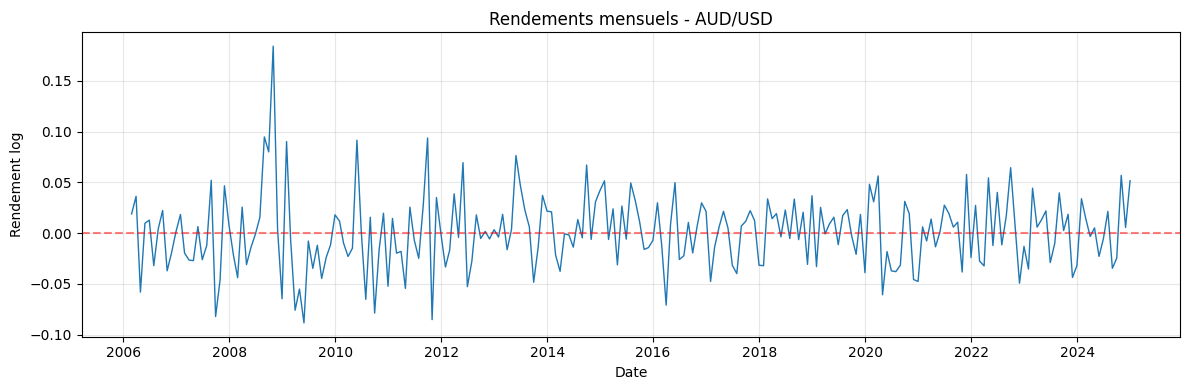

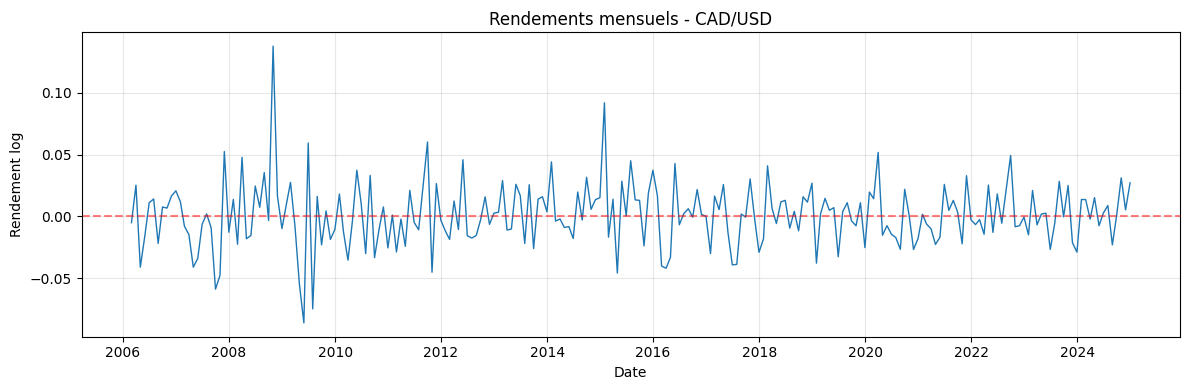

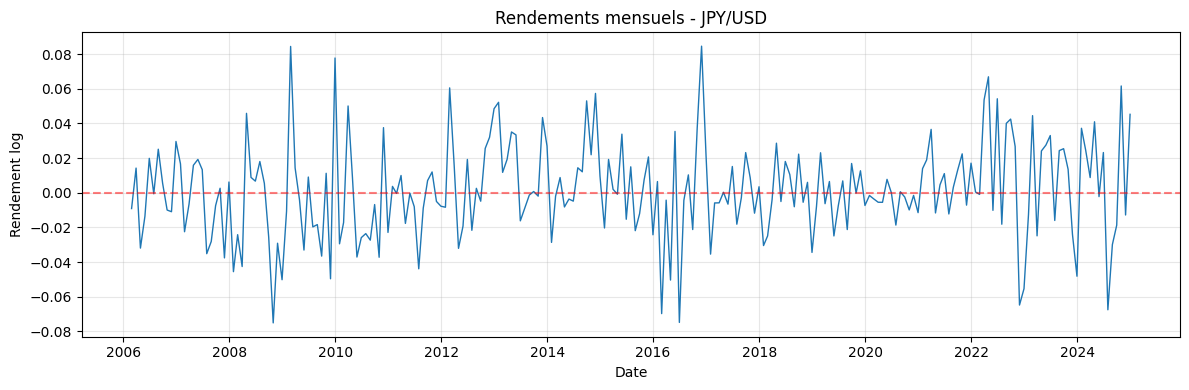

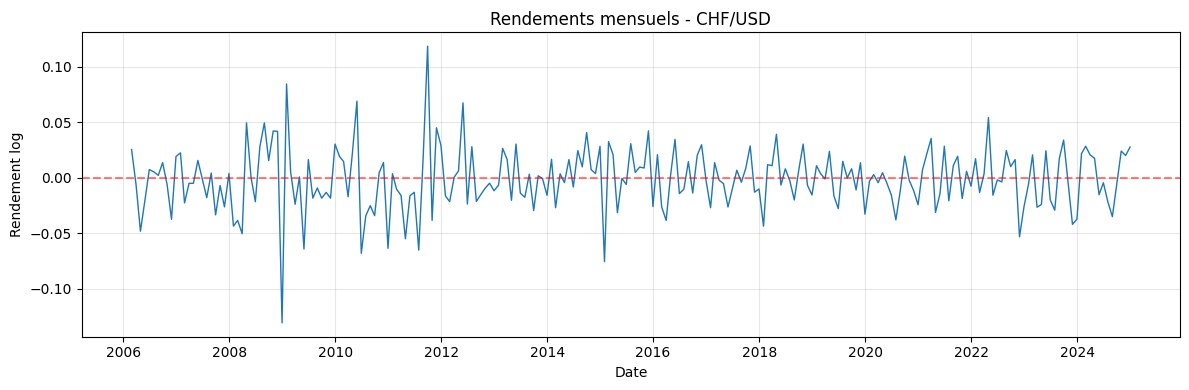

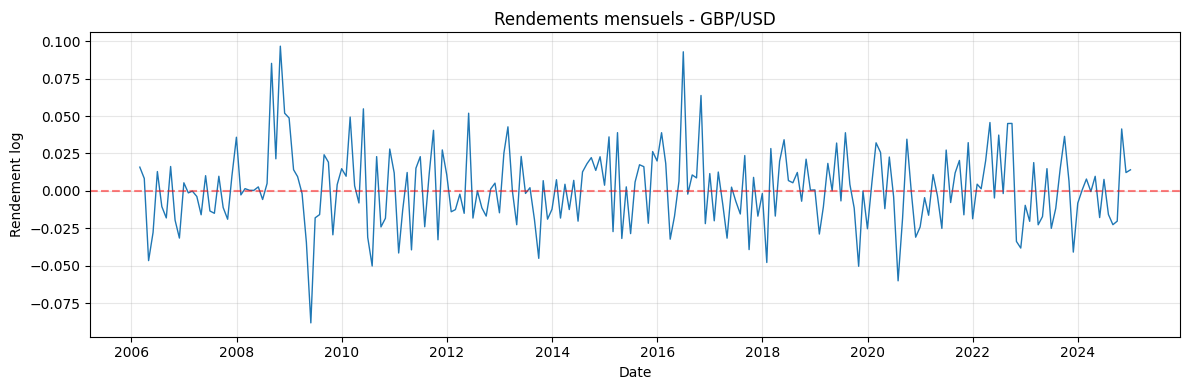

In [11]:
# Graphiques rendements devises 
currencies_list = ['AUD', 'CAD', 'JPY', 'CHF', 'GBP']

for col in currencies_list:
    plt.figure(figsize=(12, 4))
    plt.plot(returns['date'], returns[col], linewidth=1)
    plt.title(f'Rendements mensuels - {col}/USD')
    plt.xlabel('Date')
    plt.ylabel('Rendement log')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Analyse en Composantes Principales (ACP)

## Préparation des données pour l'ACP

In [12]:
returns_matrix = returns[['AUD', 'CAD', 'JPY', 'CHF', 'GBP']].values

# Dimensions matrice
print(f"Dimensions de la matrice des rendements : {returns_matrix.shape}")
print(f"{returns_matrix.shape[0]} observations (mois)")
print(f"{returns_matrix.shape[1]} variables (devises)")

# Standardiser données : (X - moyenne) / écart-type
returns_mean = np.mean(returns_matrix, axis=0)
returns_std = np.std(returns_matrix, axis=0, ddof=1)
returns_standardized = (returns_matrix - returns_mean) / returns_std

print(f"\nVérification de la standardisation :")
std_means = np.mean(returns_standardized, axis=0)
std_stds = np.std(returns_standardized, axis=0, ddof=1)

for i, currency in enumerate(['AUD', 'CAD', 'JPY', 'CHF', 'GBP']):    print(f"  {currency}: moyenne = {std_means[i]:.2e}, écart-type = {std_stds[i]:.4f}")

Dimensions de la matrice des rendements : (227, 5)
227 observations (mois)
5 variables (devises)

Vérification de la standardisation :
  AUD: moyenne = -7.83e-18, écart-type = 1.0000
  CAD: moyenne = 9.78e-18, écart-type = 1.0000
  JPY: moyenne = -1.57e-17, écart-type = 1.0000
  CHF: moyenne = -3.13e-17, écart-type = 1.0000
  GBP: moyenne = 3.91e-18, écart-type = 1.0000


## Calcul de la matrice de variance

In [13]:
# Faire matrice de covariance des données standardisées
n = returns_standardized.shape[0]
cov_matrix_standardized = (returns_standardized.T @ returns_standardized) / (n - 1)

print("Matrice de covariance des données standardisées :")
print(pd.DataFrame(
    cov_matrix_standardized,
    index=['AUD', 'CAD', 'JPY', 'CHF', 'GBP'],
    columns=['AUD', 'CAD', 'JPY', 'CHF', 'GBP']
).round(4))


Matrice de covariance des données standardisées :
        AUD     CAD     JPY     CHF     GBP
AUD  1.0000  0.7607  0.1587  0.5909  0.5883
CAD  0.7607  1.0000  0.0846  0.4014  0.5766
JPY  0.1587  0.0846  1.0000  0.3990  0.0804
CHF  0.5909  0.4014  0.3990  1.0000  0.4650
GBP  0.5883  0.5766  0.0804  0.4650  1.0000


## Extraction des valeurs propres et vecteurs propres

In [14]:
# Valeurs propres et vecteurs propres de la matrice
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_standardized)

# Trier par ordre décroissant des valeurs propres
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("Valeurs propres (variance expliquée par chaque PC) :")
for i, val in enumerate(eigenvalues, 1):
    print(f"  PC{i}: {val:.6f}")

print("\nVecteurs propres :")
loadings_df = pd.DataFrame(
    eigenvectors,
    index=['AUD', 'CAD', 'JPY', 'CHF', 'GBP'],
    columns=[f'PC{i}' for i in range(1, len(eigenvalues) + 1)]
)
print(loadings_df.round(4))

Valeurs propres (variance expliquée par chaque PC) :
  PC1: 2.774416
  PC2: 1.088634
  PC3: 0.494104
  PC4: 0.444270
  PC5: 0.198577

Vecteurs propres :
        PC1     PC2     PC3     PC4     PC5
AUD -0.5372 -0.1425  0.2548  0.2919 -0.7356
CAD -0.4951 -0.2920  0.5623 -0.0524  0.5921
JPY -0.1957  0.8477  0.3038 -0.3824 -0.0679
CHF -0.4575  0.3527 -0.4998  0.5628  0.3159
GBP -0.4677 -0.2268 -0.5261 -0.6702 -0.0626


## Calcul des composantes principales

In [15]:
# Composantes principales
principal_components = returns_standardized @ eigenvectors

pc_df = pd.DataFrame(
    principal_components,
    columns=[f'PC{i}' for i in range(1, len(currencies_list) + 1)]
)
pc_df.insert(0, 'date', returns['date'].values)

print("\nStatistiques descriptives des PCs :")
print(pc_df[[f'PC{i}' for i in range(1, len(currencies_list) + 1)]].describe())

print(pc_df)


Statistiques descriptives des PCs :
                PC1           PC2           PC3           PC4           PC5
count  2.270000e+02  2.270000e+02  2.270000e+02  2.270000e+02  2.270000e+02
mean   2.347608e-17 -2.347608e-17  3.423595e-18 -1.565072e-17 -4.890850e-18
std    1.665658e+00  1.043376e+00  7.029251e-01  6.665355e-01  4.456198e-01
min   -7.240529e+00 -4.887899e+00 -2.823153e+00 -3.627779e+00 -1.496822e+00
25%   -9.966893e-01 -5.349054e-01 -4.300159e-01 -3.704592e-01 -2.610088e-01
50%   -7.078948e-04  7.636816e-02 -2.069956e-02  2.688891e-02  2.012341e-02
75%    1.112749e+00  6.076645e-01  4.682735e-01  4.161838e-01  2.737480e-01
max    5.889302e+00  3.019292e+00  2.722750e+00  2.266121e+00  1.743297e+00
          date       PC1       PC2       PC3       PC4       PC5
0   2006-02-28 -0.777177 -0.109470 -0.890349  0.467081 -0.211149
1   2006-03-31 -1.122834 -0.143502  0.871344 -0.221151 -0.267352
2   2006-04-30  3.550095 -0.475854  0.125874  0.375810 -0.097293
3   2006-05-31  1.1

## Analyse de la variance expliquée

In [16]:
# Calculer la variance expliquée 
total_variance = np.sum(eigenvalues)
explained_variance_ratio = eigenvalues / total_variance
cumulative_variance = np.cumsum(explained_variance_ratio)

variance_df = pd.DataFrame({
    'Composante': [f'PC{i}' for i in range(1, len(eigenvalues) + 1)],
    'Valeur propre': eigenvalues,
    'Variance expliquée (%)': explained_variance_ratio * 100,
    'Variance cumulée (%)': cumulative_variance * 100
})

print("Tableau de variance expliquée :")
print(variance_df.round(2))

Tableau de variance expliquée :
  Composante  Valeur propre  Variance expliquée (%)  Variance cumulée (%)
0        PC1           2.77                   55.49                 55.49
1        PC2           1.09                   21.77                 77.26
2        PC3           0.49                    9.88                 87.14
3        PC4           0.44                    8.89                 96.03
4        PC5           0.20                    3.97                100.00


## Scree Plot ACP

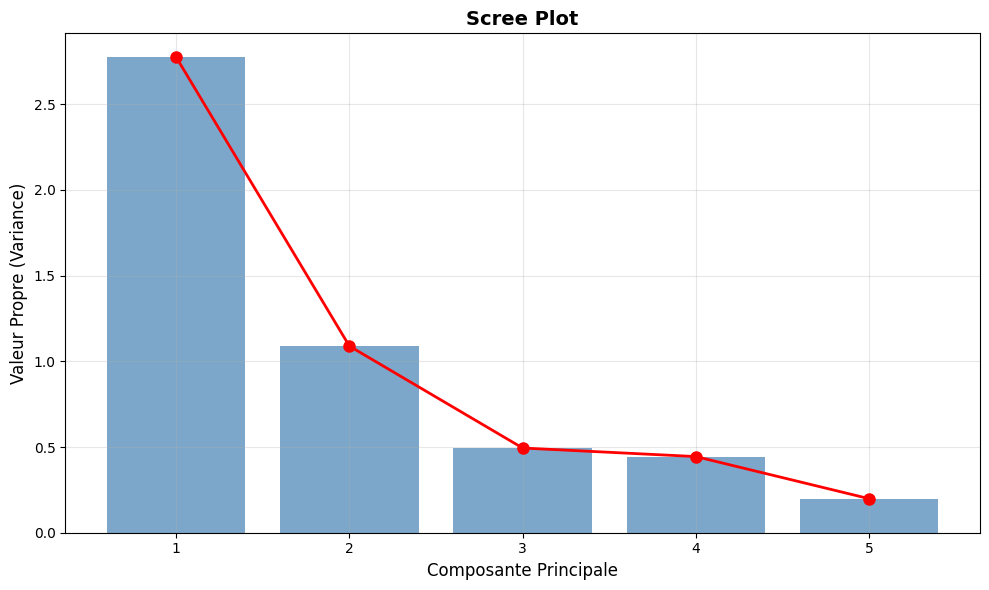

In [17]:
# Scree plot
fig, ax = plt.subplots(figsize=(10, 6))

n_components = len(eigenvalues)

ax.bar(range(1, n_components + 1), eigenvalues, alpha=0.7, color='steelblue')
ax.plot(range(1, n_components + 1), eigenvalues, 'ro-', linewidth=2, markersize=8)
ax.set_xlabel('Composante Principale', fontsize=12)
ax.set_ylabel('Valeur Propre (Variance)', fontsize=12)
ax.set_title('Scree Plot', fontsize=14, fontweight='bold')
ax.set_xticks(range(1, n_components + 1))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Modèle Factoriel V1

## Préparation des données 

### S&P 500

In [18]:
db = wrds.Connection(wrds_username='lilas_bertot')

Loading library list...
Done


In [19]:
# Extraction S&P 500 avec WRDS (CRSP Daily Stock Indexes)
spx_query = """
SELECT date, spindx
FROM crsp.dsi
WHERE date >= '2006-01-01'
AND spindx IS NOT NULL
ORDER BY date;
"""
spx_data = db.raw_sql(spx_query, date_cols=['date'])
spx_data['date'] = pd.to_datetime(spx_data['date'])

spx_data = spx_data.rename(columns={'spindx': 'SP500'})
spx_data = spx_data.dropna()

print(f"Période : {spx_data['date'].min()} à {spx_data['date'].max()}")
print(f"\nStatistiques descriptives du S&P 500 :")
print(spx_data['SP500'].describe())

Période : 2006-01-03 00:00:00 à 2024-12-31 00:00:00

Statistiques descriptives du S&P 500 :
count         4781.0
mean     2414.514328
std      1281.689708
min           676.53
25%          1353.22
50%          2050.63
75%          3128.21
max          6090.27
Name: SP500, dtype: Float64


In [20]:
print(spx_data)

           date    SP500
0    2006-01-03   1268.8
1    2006-01-04  1273.46
2    2006-01-05  1273.48
3    2006-01-06  1285.45
4    2006-01-09  1290.15
...         ...      ...
4776 2024-12-24  6040.04
4777 2024-12-26  6037.59
4778 2024-12-27  5970.84
4779 2024-12-30  5906.94
4780 2024-12-31  5881.63

[4781 rows x 2 columns]


In [21]:
# Convertir S&P 500 en fréquence mensuelle (fin de mois) 
spx_temp = spx_data.copy()
spx_temp = spx_temp.set_index('date')

# Prendre le dernier prix du mois
sp500_monthly = spx_temp.resample('ME').last()
sp500_monthly = sp500_monthly.dropna()
sp500_monthly = sp500_monthly.reset_index()

# Calculer les rendements logarithmiques mensuels 
sp500_monthly['sp500_return'] = np.log(sp500_monthly['SP500'] / sp500_monthly['SP500'].shift(1))

# Supprimer la première observation (NA)
sp500_monthly = sp500_monthly.dropna()


print(f"Période : {sp500_monthly['date'].min()} à {sp500_monthly['date'].max()}")
print(f"Observations : {len(returns)}")
print(f"Alignement : {'OUI' if len(sp500_monthly) == len(returns) else 'NON'}")
print(f"\nStatistiques descriptives des rendements log mensuels du S&P 500 :")
print(sp500_monthly['sp500_return'].describe())

print(sp500_monthly[['date', 'SP500', 'sp500_return']])


Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00
Observations : 227
Alignement : OUI

Statistiques descriptives des rendements log mensuels du S&P 500 :
count       227.0
mean     0.006718
std      0.044618
min     -0.185636
25%     -0.017617
50%      0.012782
75%      0.033843
max      0.119421
Name: sp500_return, dtype: Float64
          date    SP500  sp500_return
1   2006-02-28  1280.66      0.000453
2   2006-03-31  1294.83      0.011004
3   2006-04-30  1310.61      0.012113
4   2006-05-31  1270.09     -0.031405
5   2006-06-30   1270.2      0.000087
..         ...      ...           ...
223 2024-08-31   5648.4      0.022578
224 2024-09-30  5762.48      0.019996
225 2024-10-31  5705.45     -0.009946
226 2024-11-30  6032.38       0.05572
227 2024-12-31  5881.63     -0.025308

[227 rows x 3 columns]


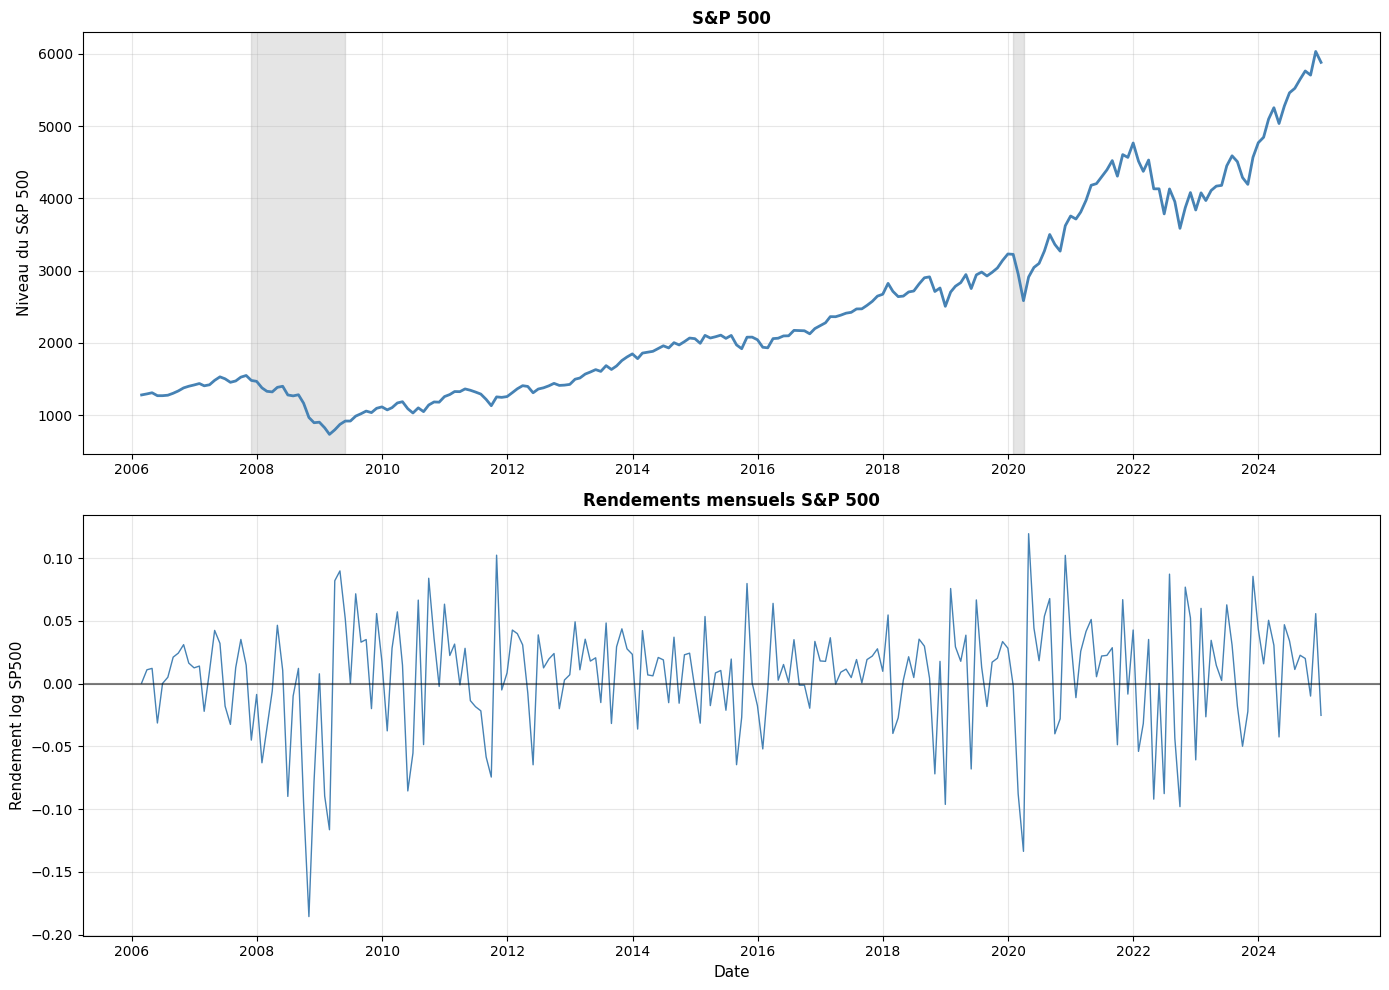

In [22]:
# Graphiques S&P 500 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Évolution niveau du S&P 500
ax1.plot(sp500_monthly['date'], sp500_monthly['SP500'], linewidth=2, color='steelblue')
ax1.set_title('S&P 500', fontsize=12, fontweight='bold')
ax1.set_ylabel('Niveau du S&P 500', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.axvspan(pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-01'), alpha=0.2, color='grey')
ax1.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-01'), alpha=0.2, color='grey')

# Rendements mensuels
ax2.plot(sp500_monthly['date'], sp500_monthly['sp500_return'], linewidth=1, color='steelblue')
ax2.set_title('Rendements mensuels S&P 500', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Rendement log SP500', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

### GOLD

In [23]:
# Télécharger les données Gold futures avec Yahoo Finance
gold_ticker = yf.Ticker("GC=F")
gold_data = gold_ticker.history(start="2006-01-01", end="2025-01-01")

gold_data = gold_data.reset_index()
gold_data = gold_data.rename(columns={'Date': 'date', 'Close': 'gold_price'})

# Convertir en fréquence mensuelle (dernier jour du mois)
gold_data_temp = gold_data[['date', 'gold_price']].copy()
gold_data_temp = gold_data_temp.set_index('date')
gold_monthly = gold_data_temp.resample('ME').last()
gold_monthly = gold_monthly.dropna()

# Calculer les rendements logarithmiques mensuels
gold_monthly['gold_return'] = np.log(gold_monthly['gold_price'] / gold_monthly['gold_price'].shift(1))

gold_monthly = gold_monthly.dropna()

gold_monthly = gold_monthly.reset_index()

# Filtrer pour la période d'analyse (2006-02-28 à 2024-12-31)
gold_monthly = gold_monthly[gold_monthly['date'] >= '2006-02-01'].copy()

# Supprimer le timezone pour permettre le merge avec d'autres DataFrames
gold_monthly_no_tz = gold_monthly.copy()
gold_monthly_no_tz['date'] = gold_monthly_no_tz['date'].dt.tz_localize(None)

print(f"\nDonnées Gold mensuelles après traitement :")
print(f"Période : {gold_monthly['date'].min()} à {gold_monthly['date'].max()}")
print(f"Observations : {len(gold_monthly)}")
print(f"\nStatistiques des rendements Gold :")
print(gold_monthly['gold_return'].describe())

print(gold_monthly_no_tz)


Données Gold mensuelles après traitement :
Période : 2006-02-28 00:00:00-05:00 à 2024-12-31 00:00:00-05:00
Observations : 227

Statistiques des rendements Gold :
count    227.000000
mean       0.006729
std        0.048206
min       -0.198512
25%       -0.022077
50%        0.004881
75%        0.035938
max        0.129863
Name: gold_return, dtype: float64
          date   gold_price  gold_return
0   2006-02-28   561.599976    -0.016249
1   2006-03-31   581.799988     0.035337
2   2006-04-30   651.799988     0.113611
3   2006-05-31   642.500000    -0.014371
4   2006-06-30   613.500000    -0.046187
..         ...          ...          ...
222 2024-08-31  2493.800049     0.027358
223 2024-09-30  2636.100098     0.055493
224 2024-10-31  2738.300049     0.038037
225 2024-11-30  2657.000000    -0.030140
226 2024-12-31  2629.199951    -0.010518

[227 rows x 3 columns]


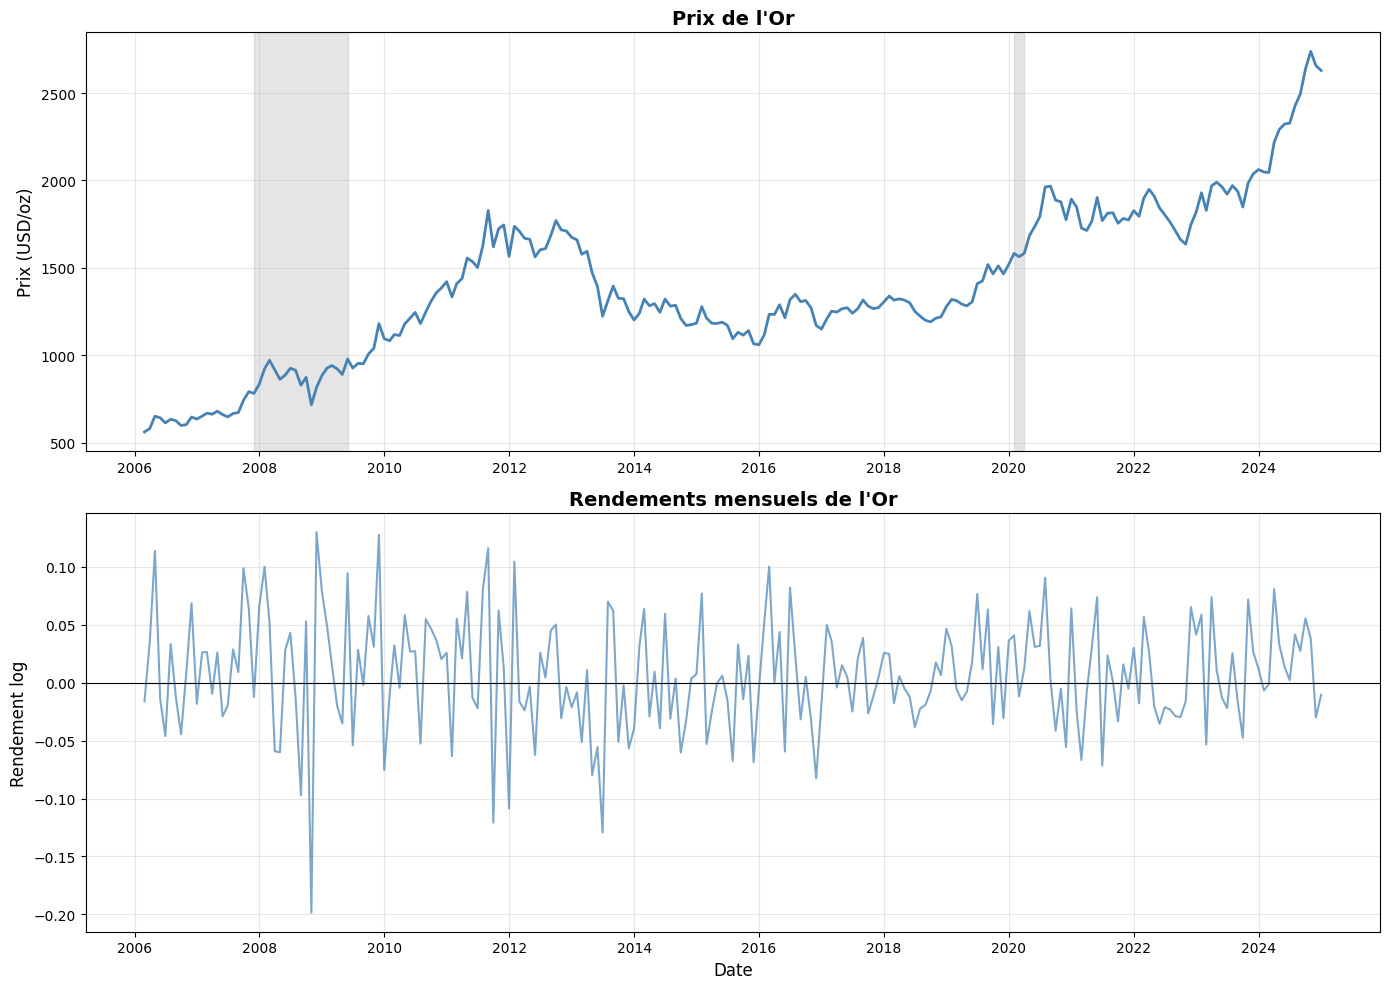

In [24]:
# Graphique Gold
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Évolution du prix de l'or
axes[0].plot(gold_monthly['date'], gold_monthly['gold_price'], color='steelblue', linewidth=2)
axes[0].set_title('Prix de l\'Or', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Prix (USD/oz)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].axvspan(pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-01'), alpha=0.2, color='grey')
axes[0].axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-01'), alpha=0.2, color='grey')

# Rendements Gold
axes[1].plot(gold_monthly['date'], gold_monthly['gold_return'], color='steelblue', linewidth=1.5, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_title('Rendements mensuels de l\'Or', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Rendement log', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Fusion données

In [25]:
# Fusionner les rendements des devises avec les 2 facteurs observables (SP500 et GOLD)
regression_data = returns.merge(
    sp500_monthly[['date', 'sp500_return']], on='date', how='inner'
).merge(
    gold_monthly_no_tz[['date', 'gold_return']], on='date', how='inner'
)

regression_data = regression_data.rename(columns={
    'sp500_return': 'SP500',
    'gold_return': 'GOLD'
})

currencies_list = ['AUD', 'CAD', 'JPY', 'CHF', 'GBP']

print(f"Données pour la régression factorielle V1")
print(f"Période : {regression_data['date'].min()} à {regression_data['date'].max()}")
print(f"Observations : {len(regression_data)}")

print("\nStatistiques des variables :")
print(regression_data[currencies_list + ['SP500', 'GOLD']].describe())

Données pour la régression factorielle V1
Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00
Observations : 227

Statistiques des variables :
              AUD         CAD         JPY         CHF         GBP     SP500  \
count  227.000000  227.000000  227.000000  227.000000  227.000000     227.0   
mean     0.000891    0.001015    0.001310   -0.001513    0.001555  0.006718   
std      0.036235    0.025754    0.027756    0.027941    0.025748  0.044618   
min     -0.088366   -0.085832   -0.075052   -0.130846   -0.087979 -0.185636   
25%     -0.022898   -0.014477   -0.015629   -0.017888   -0.016751 -0.017617   
50%      0.001296    0.000561   -0.000611   -0.002398    0.000785  0.012782   
75%      0.021490    0.015540    0.017546    0.016298    0.015554  0.033843   
max      0.184246    0.137416    0.084550    0.118363    0.096575  0.119421   

             GOLD  
count  227.000000  
mean     0.006729  
std      0.048206  
min     -0.198512  
25%     -0.022077  
50%      0.004881  
75%  

In [26]:
print(regression_data)

          date       AUD       CAD       JPY       CHF       GBP     SP500  \
0   2006-02-28  0.018931 -0.004997 -0.009111  0.025257  0.015894  0.000453   
1   2006-03-31  0.036318  0.025252  0.014231 -0.006581  0.008359  0.011004   
2   2006-04-30 -0.058019 -0.040840 -0.031913 -0.048287 -0.046452  0.012113   
3   2006-05-31  0.009794 -0.015835 -0.013537 -0.020514 -0.027713 -0.031405   
4   2006-06-30  0.012850  0.011093  0.019845  0.007211  0.012949  0.000087   
..         ...       ...       ...       ...       ...       ...       ...   
222 2024-08-31 -0.034590 -0.022932 -0.029901 -0.035168 -0.022487  0.022578   
223 2024-09-30 -0.024675  0.001333 -0.018673 -0.005786 -0.020128  0.019996   
224 2024-10-31  0.056972  0.031186  0.061589  0.023872  0.041369 -0.009946   
225 2024-11-30  0.005665  0.005366 -0.012816  0.019921  0.012287   0.05572   
226 2024-12-31  0.051673  0.027171  0.045235  0.027503  0.014116 -0.025308   

         GOLD  
0   -0.016249  
1    0.035337  
2    0.113611  

## Régression V1

$$\text{Rendement}_{i,t} = \alpha + \beta_1 \cdot \text{SP500}_t + \beta_2 \cdot \text{GOLD}_t + \varepsilon_{i,t}$$


In [27]:
# Empiler tous les rendements des devises dans un seul vecteur

all_returns = []
all_sp500 = []
all_gold = []

# Empiler les données pour chaque devise
for currency in currencies_list:
    all_returns.extend(regression_data[currency].values)
    all_sp500.extend(regression_data['SP500'].values)
    all_gold.extend(regression_data['GOLD'].values)

# Convertir en arrays numpy
y_pooled = np.array(all_returns)
X_pooled = np.column_stack([all_sp500, all_gold])
X_pooled = sm.add_constant(X_pooled)

# Nettoyer valeurs infinies et NaN
data_temp = pd.DataFrame({
    'y': y_pooled,
    'x1': X_pooled[:, 1],
    'x2': X_pooled[:, 2]
})

data_temp = data_temp.replace([np.inf, -np.inf], np.nan).dropna()

# Reconstruire y_pooled et X_pooled nettoyés
y_pooled = data_temp['y'].values
X_pooled = data_temp[['x1', 'x2']].values
X_pooled = sm.add_constant(X_pooled)

# Renommer les colonnes pour clarté
X_pooled = pd.DataFrame(X_pooled, columns=['const', 'SP500', 'GOLD'])

# Estimation OLS
model_pooled_v1 = sm.OLS(y_pooled, X_pooled)
result_pooled_v1 = model_pooled_v1.fit()

print(result_pooled_v1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     208.3
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           9.69e-78
Time:                        18:25:06   Log-Likelihood:                 2589.4
No. Observations:                1135   AIC:                            -5173.
Df Residuals:                    1132   BIC:                            -5158.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      4.804      0.0

## Contributions marginales variance V1

In [28]:
# R² 
r2_complet_v1 = result_pooled_v1.rsquared

valid_indices = data_temp.index.tolist()

all_sp500_clean = np.array(all_sp500)[valid_indices]
all_gold_clean = np.array(all_gold)[valid_indices]

# Modèle sans SP500 (GOLD uniquement)
X_sans_sp500 = np.column_stack([all_gold_clean])
X_sans_sp500 = sm.add_constant(X_sans_sp500)
model_sans_sp500 = sm.OLS(y_pooled, X_sans_sp500).fit()
r2_sans_sp500 = model_sans_sp500.rsquared

# Modèle sans GOLD (SP500 uniquement)
X_sans_gold = np.column_stack([all_sp500_clean])
X_sans_gold = sm.add_constant(X_sans_gold)
model_sans_gold = sm.OLS(y_pooled, X_sans_gold).fit()
r2_sans_gold = model_sans_gold.rsquared

# Contributions marginales V1
contrib_sp500_v1 = r2_complet_v1 - r2_sans_sp500
contrib_gold_v1 = r2_complet_v1 - r2_sans_gold

# Tableau récapitulatif
contributions_v1_df = pd.DataFrame({
    'Facteur': ['SP500', 'GOLD', 'TOTAL'],
    'Contribution marginale (%)': [
        contrib_sp500_v1 * 100,
        contrib_gold_v1 * 100,
        r2_complet_v1 * 100
    ],
    '% du R² total': [
        (contrib_sp500_v1 / r2_complet_v1) * 100 if r2_complet_v1 > 0 else 0,
        (contrib_gold_v1 / r2_complet_v1) * 100 if r2_complet_v1 > 0 else 0,
        100.0
    ]
})

print("Décomposition des contributions marginales régression V1")
print(contributions_v1_df.to_string(index=False))

Décomposition des contributions marginales régression V1
Facteur  Contribution marginale (%)  % du R² total
  SP500                   12.656660      47.055428
   GOLD                   11.634983      43.257000
  TOTAL                   26.897342     100.000000


# Modèle Factoriel V2

## Préparation des données 

### DXY

In [29]:
# Extraction données
dxy_data = pd.read_csv('DXY.csv')
dxy_data.columns = ['date', 'DXY']
dxy_data['date'] = pd.to_datetime(dxy_data['date'])

print(f"Observations quotidiennes : {len(dxy_data)}")
print(f"Période : {dxy_data['date'].min()} à {dxy_data['date'].max()}")
print(f"\nStatistiques descriptives du DXY :")
print(dxy_data['DXY'].describe())

print(dxy_data)

Observations quotidiennes : 4957
Période : 2006-01-02 00:00:00 à 2024-12-31 00:00:00

Statistiques descriptives du DXY :
count    4763.00000
mean      105.14131
std        12.02987
min        85.46920
25%        93.52200
50%       107.03350
75%       115.48280
max       129.48800
Name: DXY, dtype: float64
           date       DXY
0    2006-01-02  101.4155
1    2006-01-03  100.7558
2    2006-01-04  100.2288
3    2006-01-05  100.2992
4    2006-01-06  100.0241
...         ...       ...
4952 2024-12-25       NaN
4953 2024-12-26  128.5679
4954 2024-12-27  128.6972
4955 2024-12-30  129.0474
4956 2024-12-31  129.4880

[4957 rows x 2 columns]


In [30]:
# Convertir DXY en fréquence mensuelle (dernier jour du mois)
dxy_data_temp = dxy_data.set_index('date')
dxy_monthly = dxy_data_temp.resample('ME').last()
dxy_monthly = dxy_monthly.dropna()
dxy_monthly = dxy_monthly.reset_index()

print(f"Données mensuelles DXY : {len(dxy_monthly)} observations")
print(f"Période : {dxy_monthly['date'].min()} à {dxy_monthly['date'].max()}")

print(dxy_monthly.head(10))

Données mensuelles DXY : 228 observations
Période : 2006-01-31 00:00:00 à 2024-12-31 00:00:00
        date       DXY
0 2006-01-31   99.4311
1 2006-02-28   99.7695
2 2006-03-31  100.5600
3 2006-04-30   98.1412
4 2006-05-31   97.7705
5 2006-06-30   98.2483
6 2006-07-31   97.9996
7 2006-08-31   97.6440
8 2006-09-30   98.1054
9 2006-10-31   97.3901


In [31]:
# Calculer le rendement logarithmique du DXY
dxy_monthly['dxy_return'] = np.log(dxy_monthly['DXY'] / dxy_monthly['DXY'].shift(1))

dxy_monthly = dxy_monthly.dropna()

# Filtrage : Période commune (2006-02-28 à 2024-12-31)
dxy_monthly = dxy_monthly[dxy_monthly['date'] >= '2006-02-28'].copy()

print(f"Période : {dxy_monthly['date'].min()} à {dxy_monthly['date'].max()}")
print(f"Observations : {len(dxy_monthly)}")
print(f"Alignement : {'OUI' if len(dxy_monthly) == len(returns) else 'NON'}")
print(f"\nStatistiques des rendements log mensuels du DXY :")
print(dxy_monthly['dxy_return'].describe())

print(dxy_monthly[['date', 'DXY', 'dxy_return']])

Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00
Observations : 227
Alignement : OUI

Statistiques des rendements log mensuels du DXY :
count    227.000000
mean       0.001164
std        0.017449
min       -0.049518
25%       -0.010043
50%       -0.000726
75%        0.012417
max        0.076948
Name: dxy_return, dtype: float64
          date       DXY  dxy_return
1   2006-02-28   99.7695    0.003398
2   2006-03-31  100.5600    0.007892
3   2006-04-30   98.1412   -0.024347
4   2006-05-31   97.7705   -0.003784
5   2006-06-30   98.2483    0.004875
..         ...       ...         ...
223 2024-08-31  122.5582   -0.011069
224 2024-09-30  121.5298   -0.008427
225 2024-10-31  125.0247    0.028352
226 2024-11-30  126.8114    0.014190
227 2024-12-31  129.4880    0.020887

[227 rows x 3 columns]


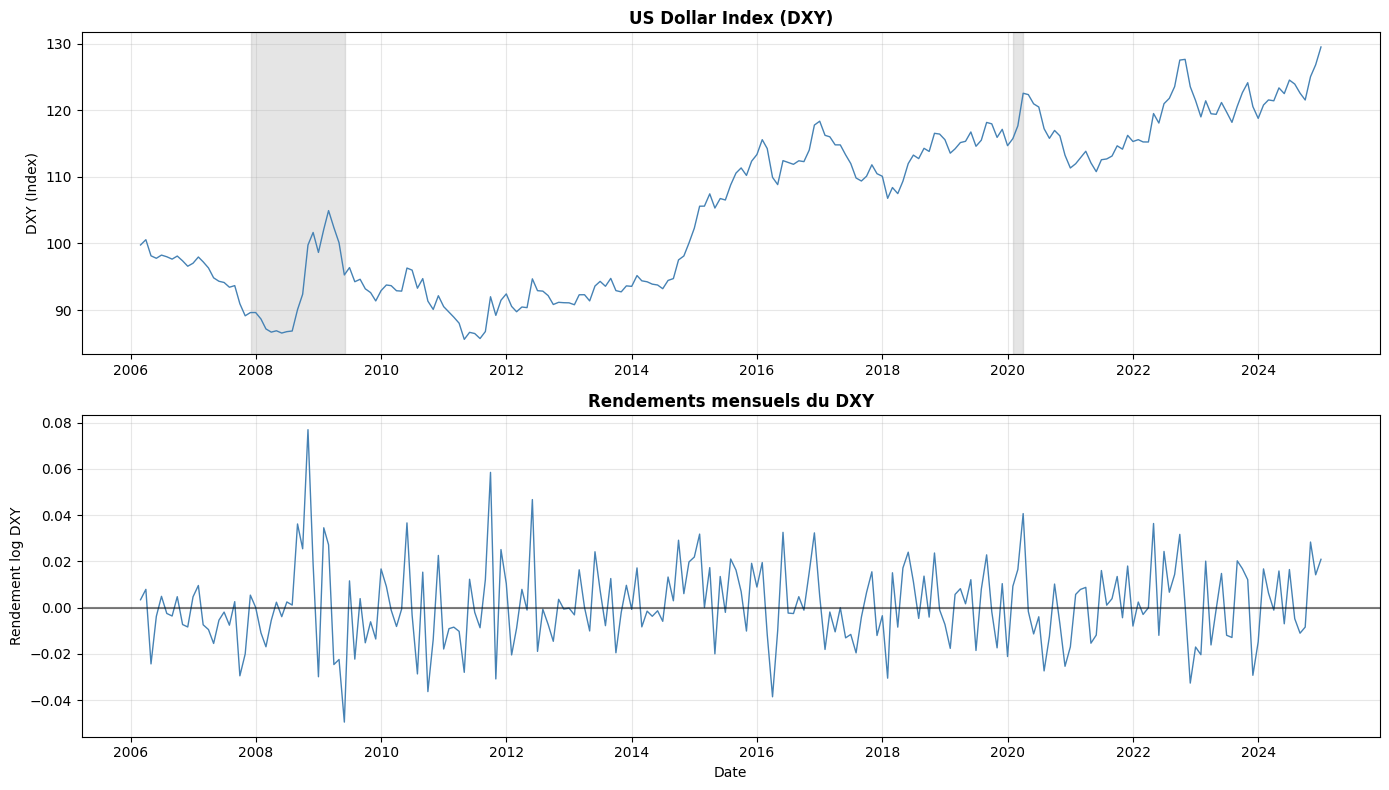

In [32]:
# Graphique DXY
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Niveau du DXY
ax1.plot(dxy_monthly['date'], dxy_monthly['DXY'], linewidth=1, color='steelblue')
ax1.set_title('US Dollar Index (DXY)', fontsize=12, fontweight='bold')
ax1.set_ylabel('DXY (Index)')
ax1.grid(True, alpha=0.3)

ax1.axvspan(pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-01'), alpha=0.2, color='grey')
ax1.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-01'), alpha=0.2, color='grey')

#Rendements logarithmiques du DXY
ax2.plot(dxy_monthly['date'], dxy_monthly['dxy_return'], linewidth=1, color='steelblue')
ax2.set_title('Rendements mensuels du DXY', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Rendement log DXY')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

### Fusion données

In [33]:
# Fusion DXY + GOLD pour V2 (même méthode que V1)
regression_data_v2 = returns.merge(
    dxy_monthly[['date', 'dxy_return']], on='date', how='inner'
).merge(
    gold_monthly_no_tz[['date', 'gold_return']], on='date', how='inner'
)

print(f"Observations : {len(regression_data_v2)} mois")
print(f"Période : {regression_data_v2['date'].min()} à {regression_data_v2['date'].max()}")
print(f"\nStatistiques descriptives :")
print(regression_data_v2[['AUD', 'CAD', 'JPY', 'CHF', 'GBP', 'dxy_return', 'gold_return']].describe())

Observations : 227 mois
Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00

Statistiques descriptives :
              AUD         CAD         JPY         CHF         GBP  dxy_return  \
count  227.000000  227.000000  227.000000  227.000000  227.000000  227.000000   
mean     0.000891    0.001015    0.001310   -0.001513    0.001555    0.001164   
std      0.036235    0.025754    0.027756    0.027941    0.025748    0.017449   
min     -0.088366   -0.085832   -0.075052   -0.130846   -0.087979   -0.049518   
25%     -0.022898   -0.014477   -0.015629   -0.017888   -0.016751   -0.010043   
50%      0.001296    0.000561   -0.000611   -0.002398    0.000785   -0.000726   
75%      0.021490    0.015540    0.017546    0.016298    0.015554    0.012417   
max      0.184246    0.137416    0.084550    0.118363    0.096575    0.076948   

       gold_return  
count   227.000000  
mean      0.006729  
std       0.048206  
min      -0.198512  
25%      -0.022077  
50%       0.004881  
75%       0.035938

## Régression V2

$$\text{Rendement}_{i,t} = \alpha + \beta_1 \cdot \text{DXY}_t + \beta_2 \cdot \text{GOLD}_t + \varepsilon_{i,t}$$

In [34]:
# Empiler tous les rendements des devises dans un seul vecteur (même méthode que V1)
currencies_list = ['AUD', 'CAD', 'JPY', 'CHF', 'GBP']

all_returns_v2 = []
all_dxy_v2 = []
all_gold_v2 = []

# Empiler les données pour chaque devise
for currency in currencies_list:
    all_returns_v2.extend(regression_data_v2[currency].values)
    all_dxy_v2.extend(regression_data_v2['dxy_return'].values)
    all_gold_v2.extend(regression_data_v2['gold_return'].values)

y_pooled_v3_gold = np.array(all_returns_v2)
X_pooled_v3_gold = np.column_stack([all_dxy_v2, all_gold_v2])
X_pooled_v3_gold = sm.add_constant(X_pooled_v3_gold)

# Nettoyage
data_temp = pd.DataFrame({
    'y': y_pooled_v3_gold,
    'x1': X_pooled_v3_gold[:, 1],
    'x2': X_pooled_v3_gold[:, 2]
})

data_temp = data_temp.replace([np.inf, -np.inf], np.nan).dropna()

# Reconstruire y_pooled et X_pooled nettoyés
y_pooled_v3_gold = data_temp['y'].values
X_pooled_v3_gold = data_temp[['x1', 'x2']].values
X_pooled_v3_gold = sm.add_constant(X_pooled_v3_gold)

X_pooled_v3_gold = pd.DataFrame(X_pooled_v3_gold, columns=['const', 'DXY', 'GOLD'])

# Régression OLS
model_pooled_v3_gold = sm.OLS(y_pooled_v3_gold, X_pooled_v3_gold)
result_pooled_v3_gold = model_pooled_v3_gold.fit()

print(result_pooled_v3_gold.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     492.7
Date:                Mon, 15 Dec 2025   Prob (F-statistic):          1.19e-154
Time:                        18:25:07   Log-Likelihood:                 2767.0
No. Observations:                1135   AIC:                            -5528.
Df Residuals:                    1132   BIC:                            -5513.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.362      0.7

## Contributions marginales variance V2

In [35]:
# Modèle complet V2 (DXY + GOLD)
r2_complet_v3_gold = result_pooled_v3_gold.rsquared

# Contribution de DXY (modèle sans DXY = GOLD seul)
all_gold_v2_clean = np.array(all_gold_v2)
# Nettoyage
data_temp = pd.DataFrame({'y': y_pooled_v3_gold, 'x': all_gold_v2_clean})
data_temp = data_temp.replace([np.inf, -np.inf], np.nan).dropna()
X_sans_dxy_v3_gold = sm.add_constant(data_temp[['x']].values)
model_sans_dxy_v3_gold = sm.OLS(data_temp['y'].values, X_sans_dxy_v3_gold).fit()
r2_sans_dxy_v3_gold = model_sans_dxy_v3_gold.rsquared
contrib_dxy_v3_gold = r2_complet_v3_gold - r2_sans_dxy_v3_gold

# Contribution de GOLD (modèle sans GOLD = DXY seul)
all_dxy_v2_clean = np.array(all_dxy_v2)
# Nettoyage
data_temp = pd.DataFrame({'y': y_pooled_v3_gold, 'x': all_dxy_v2_clean})
data_temp = data_temp.replace([np.inf, -np.inf], np.nan).dropna()
X_sans_gold_v3_gold = sm.add_constant(data_temp[['x']].values)
model_sans_gold_v3_gold = sm.OLS(data_temp['y'].values, X_sans_gold_v3_gold).fit()
r2_sans_gold_v3_gold = model_sans_gold_v3_gold.rsquared
contrib_gold_v3_gold = r2_complet_v3_gold - r2_sans_gold_v3_gold

# Tableau récapitulatif V2
contributions_v2_df = pd.DataFrame({
    'Facteur': ['DXY', 'GOLD', 'TOTAL'],
    'Contribution marginale (%)': [
        contrib_dxy_v3_gold * 100,
        contrib_gold_v3_gold * 100,
        r2_complet_v3_gold * 100
    ],
    '% du R² total': [
        (contrib_dxy_v3_gold / r2_complet_v3_gold) * 100 if r2_complet_v3_gold > 0 else 0,
        (contrib_gold_v3_gold / r2_complet_v3_gold) * 100 if r2_complet_v3_gold > 0 else 0,
        100.0
    ]
})

print("Décomposition des contributions marginales - V2 du modèle")
print(contributions_v2_df.to_string(index=False))

Décomposition des contributions marginales - V2 du modèle
Facteur  Contribution marginale (%)  % du R² total
    DXY                   32.296616      69.399421
   GOLD                    0.592215       1.272559
  TOTAL                   46.537298     100.000000


# Modèle factoriel V3

## Préparation des données

### REER

In [36]:
# Extraire données
reer_files = {
    'US': 'REER_US.csv',
    'AU': 'REER_AU.csv', 
    'CA': 'REER_CA.csv',
    'JA': 'REER_JA.csv',
    'SW': 'REER_SW.csv',
    'UK': 'REER_UK.csv'
}

reer_data = {}


for currency, filename in reer_files.items():
    df = pd.read_csv(filename)
    df.columns = ['date', 'reer']
    df['date'] = pd.to_datetime(df['date'])

    df = df[df['date'] >= '2006-01-01'].copy()

    reer_data[currency] = df
    
    
    print(f"{currency}: {len(df)} observations, période {df['date'].min()} à {df['date'].max()}")


US: 228 observations, période 2006-01-01 00:00:00 à 2024-12-01 00:00:00
AU: 228 observations, période 2006-01-01 00:00:00 à 2024-12-01 00:00:00
CA: 228 observations, période 2006-01-01 00:00:00 à 2024-12-01 00:00:00
JA: 228 observations, période 2006-01-01 00:00:00 à 2024-12-01 00:00:00
SW: 228 observations, période 2006-01-01 00:00:00 à 2024-12-01 00:00:00
UK: 228 observations, période 2006-01-01 00:00:00 à 2024-12-01 00:00:00


In [37]:
print(reer_data[currency])

          date    reer
12  2006-01-01  122.50
13  2006-02-01  122.45
14  2006-03-01  121.52
15  2006-04-01  121.40
16  2006-05-01  125.48
..         ...     ...
235 2024-08-01  109.79
236 2024-09-01  111.16
237 2024-10-01  111.73
238 2024-11-01  111.54
239 2024-12-01  111.99

[228 rows x 2 columns]


In [38]:
# Convertir en fréquence mensuelle et calculer les variations
reer_monthly = {}

for currency, df in reer_data.items():
    # Convertir en mensuel (dernier jour du mois)
    df_temp = df.set_index('date')
    df_monthly = df_temp.resample('ME').last()
    df_monthly = df_monthly.dropna()
    df_monthly = df_monthly.reset_index()
    
    # Calculer les variations mensuelles, utiliser les variations log
    df_monthly['reer_change'] = np.log(df_monthly['reer'] / df_monthly['reer'].shift(1))
    
    df_monthly = df_monthly.dropna()
    
    # Filtrer pour la période 2006-02-28 à 2024-12-31
    df_monthly = df_monthly[df_monthly['date'] >= '2006-02-28'].copy()
    
    reer_monthly[currency] = df_monthly
    
    print(f"{currency}: {len(df_monthly)} observations mensuelles, {df_monthly['date'].min()} à {df_monthly['date'].max()}")
    

print("\nStatistiques descriptives des variations REER (log changes) :")
for currency in ['AU', 'CA', 'JA', 'SW', 'UK']:
    stats = reer_monthly[currency]['reer_change'].describe()
    print(reer_monthly[currency]['reer_change'].describe())

US: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00
AU: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00
CA: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00
JA: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00
SW: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00
UK: 227 observations mensuelles, 2006-02-28 00:00:00 à 2024-12-31 00:00:00

Statistiques descriptives des variations REER (log changes) :
count    227.000000
mean       0.000094
std        0.021667
min       -0.143937
25%       -0.011757
50%        0.001263
75%        0.013507
max        0.053665
Name: reer_change, dtype: float64
count    227.000000
mean      -0.000866
std        0.015880
min       -0.089041
25%       -0.009063
50%       -0.001134
75%        0.007744
max        0.058956
Name: reer_change, dtype: float64
count    227.000000
mean      -0.002242
std        0.022849
min       -0.068181
25%       -0.013911

In [39]:
# Construction REER pondéré
reer_factor_df = reer_monthly['AU'][['date']].copy()

# Ajouter toutes les variations REER 
reer_factor_df = reer_factor_df.merge(
    reer_monthly['AU'][['date', 'reer_change']].rename(columns={'reer_change': 'REER_AUD'}),
    on='date', how='inner'
).merge(
    reer_monthly['CA'][['date', 'reer_change']].rename(columns={'reer_change': 'REER_CAD'}),
    on='date', how='inner'
).merge(
    reer_monthly['JA'][['date', 'reer_change']].rename(columns={'reer_change': 'REER_JPY'}),
    on='date', how='inner'
).merge(
    reer_monthly['SW'][['date', 'reer_change']].rename(columns={'reer_change': 'REER_CHF'}),
    on='date', how='inner'
).merge(
    reer_monthly['UK'][['date', 'reer_change']].rename(columns={'reer_change': 'REER_GBP'}),
    on='date', how='inner'
)

# Poids PC2 exacts de l'ACP 
weights_pc2 = {
    'JPY': +0.8477,   
    'CHF': +0.3481,   
    'AUD': -0.1570,   
    'CAD': -0.3328,   
    'GBP': -0.2036    
}

# Construire le facteur REER pondéré REER_PC2 = sum(weight_i × REER_i)
reer_factor_df['REER_Factor_PC2'] = (
    weights_pc2['JPY'] * reer_factor_df['REER_JPY'] +
    weights_pc2['CHF'] * reer_factor_df['REER_CHF'] +
    weights_pc2['AUD'] * reer_factor_df['REER_AUD'] +
    weights_pc2['CAD'] * reer_factor_df['REER_CAD'] +
    weights_pc2['GBP'] * reer_factor_df['REER_GBP']
)

reer_factor_df['REER_Factor'] = reer_factor_df['REER_Factor_PC2']

print(f"{len(reer_factor_df)} observations")
print(f"Période : {reer_factor_df['date'].min()} à {reer_factor_df['date'].max()}")
print(f"\nStatistiques du facteur REER pondéré :")
print(reer_factor_df['REER_Factor'].describe())

print(reer_factor_df)

227 observations
Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00

Statistiques du facteur REER pondéré :
count    227.000000
mean      -0.001307
std        0.026052
min       -0.063566
25%       -0.015788
50%       -0.004127
75%        0.010672
max        0.157063
Name: REER_Factor, dtype: float64
          date  REER_AUD  REER_CAD  REER_JPY  REER_CHF  REER_GBP  \
0   2006-02-28 -0.004154  0.005273 -0.026625 -0.010426 -0.000408   
1   2006-03-31 -0.016202 -0.005102  0.005826 -0.008772 -0.007624   
2   2006-04-30  0.005593  0.006882 -0.010391  0.004454 -0.000988   
3   2006-05-31  0.020723  0.024424  0.034448  0.020490  0.033056   
4   2006-06-30 -0.016525 -0.001075 -0.016906 -0.001376 -0.000478   
..         ...       ...       ...       ...       ...       ...   
222 2024-08-31 -0.025309 -0.004910  0.065344  0.023644 -0.006627   
223 2024-09-30  0.005353  0.000803  0.008335  0.000973  0.012401   
224 2024-10-31  0.001012 -0.007556 -0.031095 -0.005560  0.005115   
225 2024-11-30 -0

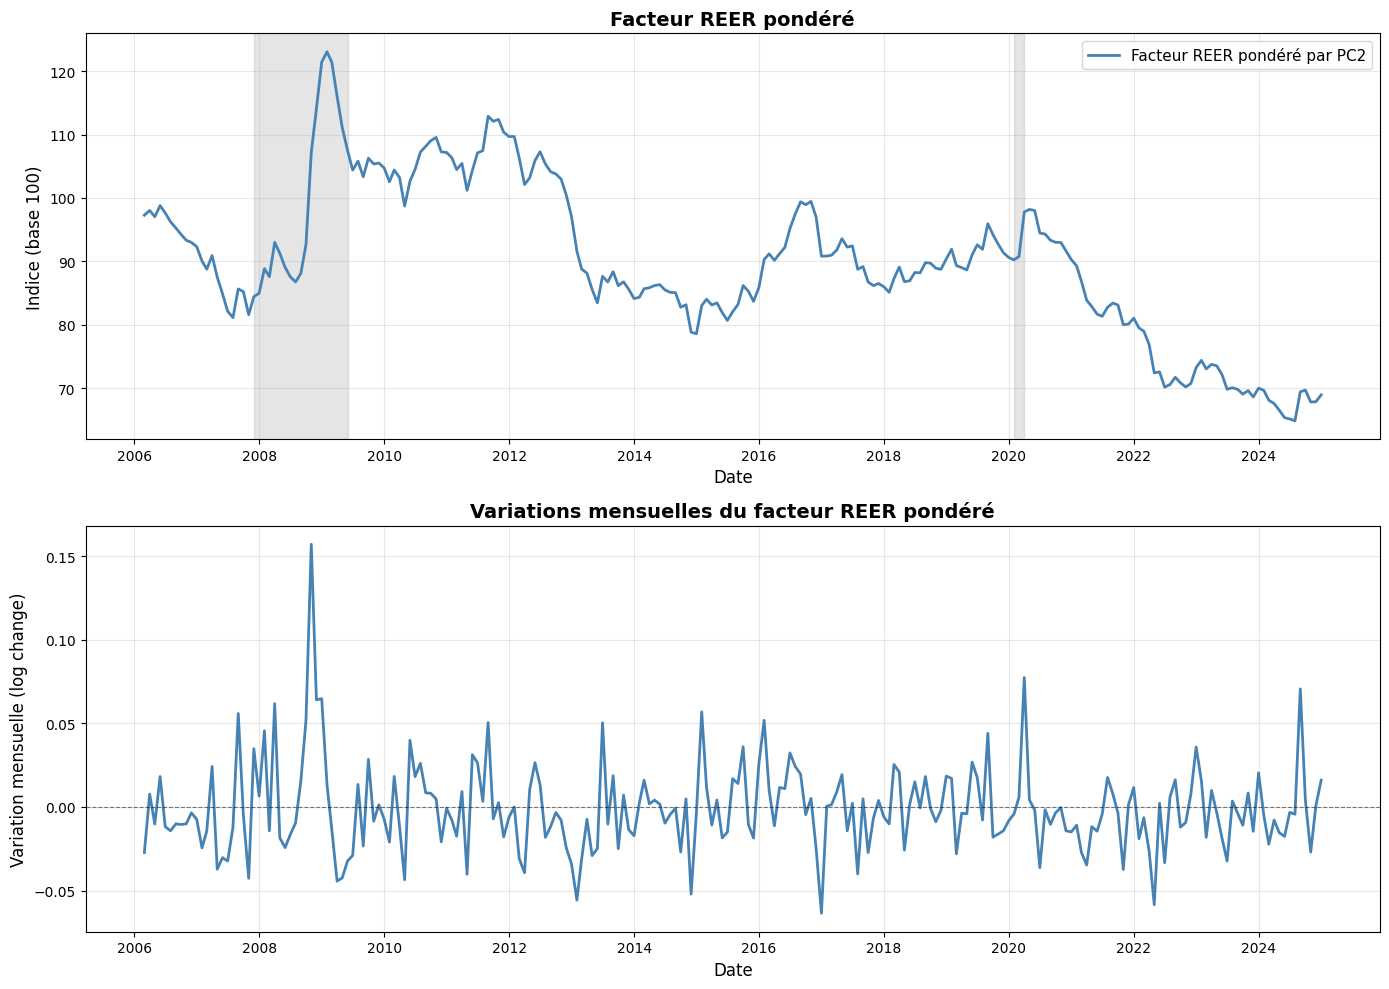

In [40]:
# Graphique REER pondéré
reer_factor_df['REER_Factor_Cumulative'] = (1 + reer_factor_df['REER_Factor']).cumprod() * 100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Niveau facteur REER pondéré
ax1.plot(reer_factor_df['date'], reer_factor_df['REER_Factor_Cumulative'], 
         color='steelblue', linewidth=2, label='Facteur REER pondéré par PC2')
ax1.set_title('Facteur REER pondéré', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Indice (base 100)', fontsize=12)
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

ax1.axvspan(pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-01'), alpha=0.2, color='grey', label='Crises')
ax1.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-01'), alpha=0.2, color='grey')

# Variations mensuelles du facteur REER pondéré
ax2.plot(reer_factor_df['date'], reer_factor_df['REER_Factor'], 
         color='steelblue', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.set_title('Variations mensuelles du facteur REER pondéré', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Variation mensuelle (log change)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



### Fusion données 

In [41]:
# Fusionner returns avec DXY et REER
regression_data_v3 = returns.merge(
    dxy_monthly[['date', 'dxy_return']], on='date', how='inner'
).merge(
    reer_factor_df[['date', 'REER_Factor']], on='date', how='inner'
)

print(f"Observations : {len(regression_data_v3)} mois")
print(f"Période : {regression_data_v3['date'].min()} à {regression_data_v3['date'].max()}")
print(f"\nStatistiques descriptives :")
print(regression_data_v3[['AUD', 'CAD', 'JPY', 'CHF', 'GBP', 'dxy_return', 'REER_Factor']].describe())

Observations : 227 mois
Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00

Statistiques descriptives :
              AUD         CAD         JPY         CHF         GBP  dxy_return  \
count  227.000000  227.000000  227.000000  227.000000  227.000000  227.000000   
mean     0.000891    0.001015    0.001310   -0.001513    0.001555    0.001164   
std      0.036235    0.025754    0.027756    0.027941    0.025748    0.017449   
min     -0.088366   -0.085832   -0.075052   -0.130846   -0.087979   -0.049518   
25%     -0.022898   -0.014477   -0.015629   -0.017888   -0.016751   -0.010043   
50%      0.001296    0.000561   -0.000611   -0.002398    0.000785   -0.000726   
75%      0.021490    0.015540    0.017546    0.016298    0.015554    0.012417   
max      0.184246    0.137416    0.084550    0.118363    0.096575    0.076948   

       REER_Factor  
count   227.000000  
mean     -0.001307  
std       0.026052  
min      -0.063566  
25%      -0.015788  
50%      -0.004127  
75%       0.010672

In [42]:
print(regression_data_v3)

          date       AUD       CAD       JPY       CHF       GBP  dxy_return  \
0   2006-02-28  0.018931 -0.004997 -0.009111  0.025257  0.015894    0.003398   
1   2006-03-31  0.036318  0.025252  0.014231 -0.006581  0.008359    0.007892   
2   2006-04-30 -0.058019 -0.040840 -0.031913 -0.048287 -0.046452   -0.024347   
3   2006-05-31  0.009794 -0.015835 -0.013537 -0.020514 -0.027713   -0.003784   
4   2006-06-30  0.012850  0.011093  0.019845  0.007211  0.012949    0.004875   
..         ...       ...       ...       ...       ...       ...         ...   
222 2024-08-31 -0.034590 -0.022932 -0.029901 -0.035168 -0.022487   -0.011069   
223 2024-09-30 -0.024675  0.001333 -0.018673 -0.005786 -0.020128   -0.008427   
224 2024-10-31  0.056972  0.031186  0.061589  0.023872  0.041369    0.028352   
225 2024-11-30  0.005665  0.005366 -0.012816  0.019921  0.012287    0.014190   
226 2024-12-31  0.051673  0.027171  0.045235  0.027503  0.014116    0.020887   

     REER_Factor  
0      -0.027219  
1

## Régression V3

$$\text{Rendement}_{i,t} = \alpha + \beta_1 \cdot \text{DXY}_t + \beta_2 \cdot \text{REER}_t + \varepsilon_{i,t}$$

In [43]:
# Empiler tous les rendements des devises dans un seul vecteur (même méthode que V1 et V2)
import statsmodels.api as sm

currencies_list = ['AUD', 'CAD', 'JPY', 'CHF', 'GBP']

all_returns_v3 = []
all_dxy_v3 = []
all_reer_v3 = []

# Empiler les données pour chaque devise
for currency in currencies_list:
    all_returns_v3.extend(regression_data_v3[currency].values)
    all_dxy_v3.extend(regression_data_v3['dxy_return'].values)
    all_reer_v3.extend(regression_data_v3['REER_Factor'].values)

y_pooled_v4 = np.array(all_returns_v3)
X_pooled_v4 = np.column_stack([all_dxy_v3, all_reer_v3])
X_pooled_v4 = sm.add_constant(X_pooled_v4)

# Nettoyage
data_temp = pd.DataFrame({
    'y': y_pooled_v4,
    'x1': X_pooled_v4[:, 1],
    'x2': X_pooled_v4[:, 2]
})

data_temp = data_temp.replace([np.inf, -np.inf], np.nan).dropna()

y_pooled_v4 = data_temp['y'].values
X_pooled_v4 = data_temp[['x1', 'x2']].values
X_pooled_v4 = sm.add_constant(X_pooled_v4)

# Renommer les colonnes pour clarté
X_pooled_v4 = pd.DataFrame(X_pooled_v4, columns=['const', 'DXY', 'REER'])

# Régression OLS
model_pooled_v4 = sm.OLS(y_pooled_v4, X_pooled_v4)
result_pooled_v4 = model_pooled_v4.fit()

print(result_pooled_v4.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     492.3
Date:                Mon, 15 Dec 2025   Prob (F-statistic):          1.45e-154
Time:                        18:25:07   Log-Likelihood:                 2766.8
No. Observations:                1135   AIC:                            -5528.
Df Residuals:                    1132   BIC:                            -5512.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -1.266      0.2

## Contributions marginales variance V3

In [44]:
# Modèle complet V3 (DXY + REER)
r2_complet_v4 = result_pooled_v4.rsquared

# Contribution de DXY (modèle sans DXY = REER seul)
all_reer_v3_clean = np.array(all_reer_v3)
# Nettoyage
data_temp = pd.DataFrame({'y': y_pooled_v4, 'x': all_reer_v3_clean})
data_temp = data_temp.replace([np.inf, -np.inf], np.nan).dropna()
X_sans_dxy_v4 = sm.add_constant(data_temp[['x']].values)
model_sans_dxy_v4 = sm.OLS(data_temp['y'].values, X_sans_dxy_v4).fit()
r2_sans_dxy_v4 = model_sans_dxy_v4.rsquared
contrib_dxy_v4 = r2_complet_v4 - r2_sans_dxy_v4

# Contribution de REER (modèle sans REER = DXY seul)
all_dxy_v3_clean = np.array(all_dxy_v3)
# Nettoyage
data_temp = pd.DataFrame({'y': y_pooled_v4, 'x': all_dxy_v3_clean})
data_temp = data_temp.replace([np.inf, -np.inf], np.nan).dropna()
X_sans_reer_v4 = sm.add_constant(data_temp[['x']].values)
model_sans_reer_v4 = sm.OLS(data_temp['y'].values, X_sans_reer_v4).fit()
r2_sans_reer_v4 = model_sans_reer_v4.rsquared
contrib_reer_v4 = r2_complet_v4 - r2_sans_reer_v4

# Tableau récapitulatif V3
contributions_v3_df = pd.DataFrame({
    'Facteur': ['DXY', 'REER', 'TOTAL'],
    'Contribution marginale (%)': [
        contrib_dxy_v4 * 100,
        contrib_reer_v4 * 100,
        r2_complet_v4 * 100
    ],
    '% du R² total': [
        (contrib_dxy_v4 / r2_complet_v4) * 100 if r2_complet_v4 > 0 else 0,
        (contrib_reer_v4 / r2_complet_v4) * 100 if r2_complet_v4 > 0 else 0,
        100.0
    ]
})

print("Décomposition des contributions marginales - V3 du modèle")
print(contributions_v3_df.to_string(index=False))



Décomposition des contributions marginales - V3 du modèle
Facteur  Contribution marginale (%)  % du R² total
    DXY                   46.207731      99.331012
   REER                    0.573853       1.233590
  TOTAL                   46.518937     100.000000


## Tableau comparatif des trois régressions

In [45]:
# Tableau récapitulatif comparatif des 3 modèles
comparaison_df = pd.DataFrame({
    'Modèle': ['V1 (SP500 + GOLD)', 'V2 (DXY + GOLD)', 'V3 (DXY + REER)'],
    'R² (%)': [
        result_pooled_v1.rsquared * 100,
        result_pooled_v3_gold.rsquared * 100,
        result_pooled_v4.rsquared * 100
    ],
    'Facteur 1': ['SP500', 'DXY', 'DXY'],
    'Coef. F1': [
        result_pooled_v1.params[1],
        result_pooled_v3_gold.params[1],
        result_pooled_v4.params[1]
    ],
    'Contrib. F1 (%)': [
        (contrib_sp500_v1 / result_pooled_v1.rsquared) * 100,
        (contrib_dxy_v3_gold / result_pooled_v3_gold.rsquared) * 100,
        (contrib_dxy_v4 / result_pooled_v4.rsquared) * 100
    ],
    'Facteur 2': ['GOLD', 'GOLD', 'REER'],
    'Coef. F2': [
        result_pooled_v1.params[2],
        result_pooled_v3_gold.params[2],
        result_pooled_v4.params[2]
    ],
    'Contrib. F2 (%)': [
        (contrib_gold_v1 / result_pooled_v1.rsquared) * 100,
        (contrib_gold_v3_gold / result_pooled_v3_gold.rsquared) * 100,
        (contrib_reer_v4 / result_pooled_v4.rsquared) * 100
    ]
})

print("Taleau comparatif des trois modèles de régression factorielle")
print(comparaison_df.to_string(index=False))

Taleau comparatif des trois modèles de régression factorielle
           Modèle    R² (%) Facteur 1  Coef. F1  Contrib. F1 (%) Facteur 2  Coef. F2  Contrib. F2 (%)
V1 (SP500 + GOLD) 26.897342     SP500 -0.232086        47.055428      GOLD -0.205962        43.257000
  V2 (DXY + GOLD) 46.537298       DXY  1.059999        69.399421      GOLD -0.051956         1.272559
  V3 (DXY + REER) 46.518937       DXY  1.150009        99.331012      REER -0.085836         1.233590
